# Inflation Regimes


In [1]:
# general 
import pandas as pd 

# for downloading data 
from fredapi import Fred

# for clustering libraries 
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# for analysis
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.filters.hp_filter import hpfilter

# to smooth series 
from tsmoothie.smoother import * 

# for plottign 
import matplotlib.pyplot as plt
import seaborn 

/Users/safishajjouz/opt/anaconda3/envs/Spyder_env/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


### Download the Data

You need to get an API from Fed St. Louis: see here https://github.com/mortada/fredapi 

In [2]:
my_fred_API = 'use your own API' # 
fred = Fred(api_key=my_fred_API)

series_to_download = ['CPIAUCSL', # CPI all items #  
                     'USACPICORMINMEI'] #CPI ex-food and energy

# choose frequency 
freq = ['m', 'q', 'a'][0]

df = {}
for series_id in series_to_download:
    info = fred.get_series_info(series_id)['title']
    print(info)
    df[series_id] = fred.get_series(series_id, frequency = freq)
df = pd.DataFrame(df)
df = df.rename(columns = {'CPIAUCSL':'CPI', 'USACPICORMINMEI':'CPI_core' })
df.head()

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
Consumer Price Index: All Items Excluding Food and Energy for the United States


,CPI,CPI_core
1947-01-01,21.48,NaN
1947-02-01,21.62,NaN
1947-03-01,22.00,NaN
1947-04-01,22.00,NaN
1947-05-01,21.95,NaN


### Data Preparation 

,inflation_CPI_annualized,inflation_core_annualized,year,inflation_CPI_annualized_ave,inflation_core_annualized_ave,inflation_cycle,inflation_trend,inflation_core_cycle,inflation_core_trend,inflation_CPI_annualized_roll_mean,inflation_core_annualized_roll_mean
Date,,,,,,,,,,,
1962-01-01,1.206218,0.000000,1962,1.250388,1.298558,0.041526,1.164692,-1.161962,1.161962,1.149407,1.163548
1962-02-01,2.832389,0.000000,1962,1.250388,1.298558,1.657728,1.174661,-1.176935,1.176935,1.198814,0.996625
1962-03-01,2.417614,3.914684,1962,1.250388,1.298558,1.232398,1.185216,2.722444,1.192241,1.299548,1.159737
1962-04-01,1.602637,0.000000,1962,1.250388,1.298558,0.406258,1.196380,-1.207899,1.207899,1.139858,1.159737
1962-05-01,1.198189,3.901957,1962,1.250388,1.298558,-0.009996,1.208184,2.678005,1.223951,1.138719,1.322319


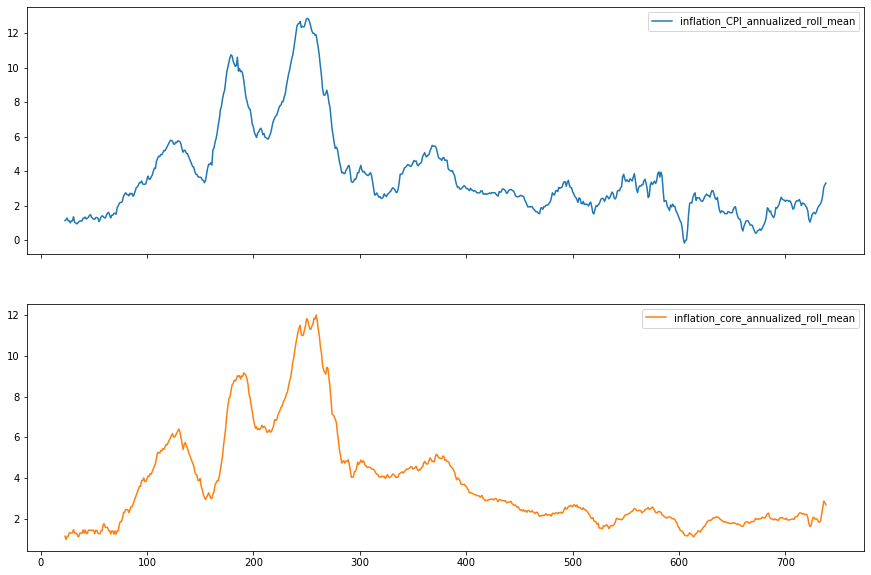

In [3]:
# Calculate m-to-m percentage change  (Inflation) 
df_inflation = df[['CPI', 'CPI_core']].pct_change().dropna()
df_inflation.columns = ['inflation_CPI', 'inflation_core']

# Annualize 
df_inflation['inflation_CPI_annualized'] = (((1 + df_inflation['inflation_CPI'])**12) - 1)*100
df_inflation['inflation_core_annualized'] = (((1 + df_inflation['inflation_core'])**12) - 1)*100
df_inflation = df_inflation.drop(['inflation_CPI', 'inflation_core'], axis = 1)

# calculate the average inflation per month 
df_inflation['year'] = pd.DatetimeIndex(df_inflation.index).year

df_average = df_inflation.groupby('year').mean()
df_average.columns = ['inflation_CPI_annualized_ave', 'inflation_core_annualized_ave']
df_inflation = pd.merge(df_inflation.reset_index().rename(columns = {'index':'Date'}), df_average.reset_index())

# decompose to trend and cycles 
df_inflation['inflation_cycle'] = hpfilter(df_inflation[['inflation_CPI_annualized']], lamb=129600)[0]
df_inflation['inflation_trend'] = hpfilter(df_inflation[['inflation_CPI_annualized']], lamb=129600)[1]
df_inflation['inflation_core_cycle'] = hpfilter(df_inflation[['inflation_core_annualized']], lamb=129600)[0]
df_inflation['inflation_core_trend'] = hpfilter(df_inflation[['inflation_core_annualized']], lamb=129600)[1]

# remove Business cycle effects [more add-hoc method that assumes business cycles typically last two years]
df_inflation[['inflation_CPI_annualized_roll_mean', 'inflation_core_annualized_roll_mean']]= df_inflation[['inflation_CPI_annualized', 'inflation_core_annualized']].rolling(24).mean().dropna()
df_inflation[['inflation_CPI_annualized_roll_mean', 'inflation_core_annualized_roll_mean']].plot(subplots = True, figsize =(15,10))

df_inflation = df_inflation.dropna()
df_inflation = df_inflation.set_index('Date')
df_inflation.head()

Text(0.5, 1.0, 'USA: Core and Headline Inflation over-time')

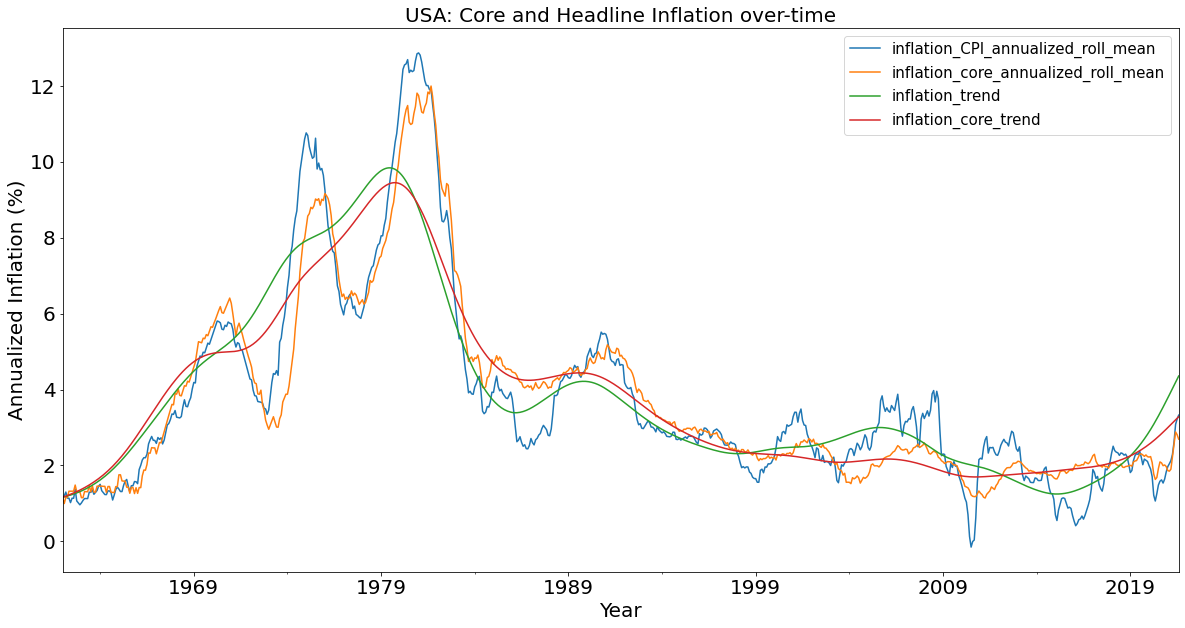

In [4]:
df_inflation[['inflation_CPI_annualized_roll_mean', 
              'inflation_core_annualized_roll_mean', 
              'inflation_trend', 'inflation_core_trend']].plot(figsize=(20,10), 
                                                              ylabel = 'Annualized Inflation',
                                                              fontsize = 20)
plt.ylabel('Annualized Inflation (%)', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.legend(fontsize=15)
plt.title('USA: Core and Headline Inflation over-time',
          fontsize = 20)

### Time series clustering 

You need to repeat this part twice to get the clustering analysis for the headline and core inflation
(sorry lazy to work out on the code) 

In [5]:
X = df_inflation[['inflation_core_trend']] # you options here are: inflation_core_trend and inflation_trend
X_scaled = normalize(X, axis=0)

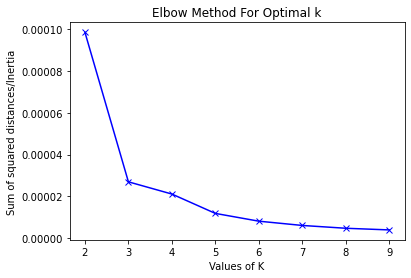

In [6]:
df_scores = []
k_values_to_try = np.arange(2, 10)
Sum_of_squared_distances = []
for n_clusters in k_values_to_try:
    #Perform clustering.
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=33)
    labels_clusters = kmeans.fit(X_scaled)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(k_values_to_try,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [7]:
# after optimal clustering 
optimal_clusters = 3
smooth_km = TimeSeriesKMeans(n_clusters=optimal_clusters, metric="dtw", max_iter=10, random_state=33)
smooth_km.fit(X_scaled)

# present reslults 
labels = smooth_km.labels_
fancy_names_for_labels = labels + 1   #[f"Cluster {label+1}" for label in labels]
df_tsclusters = pd.DataFrame(zip(df_inflation.transpose(), fancy_names_for_labels),
                           columns=["year","Regime"]).sort_values(by="year").set_index("year")
df_tsclusters.head()


,Regime
year,
1962-01-01,1
1962-02-01,1
1962-03-01,1
1962-04-01,1
1962-05-01,1


In [8]:
df_inflation['Regime_TS'] = list(smooth_km.labels_ + 1)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Inflation Regimes: Core Inflation')

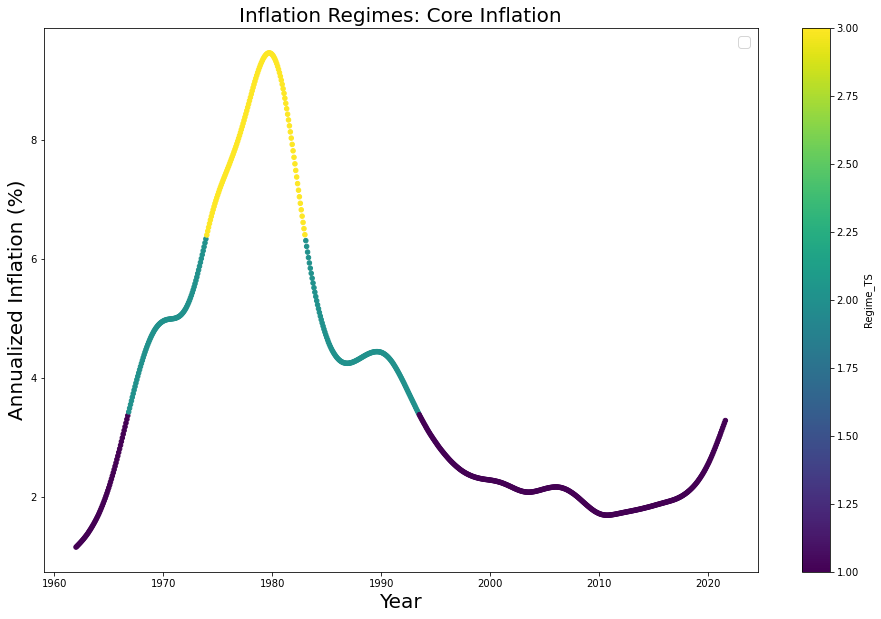

In [10]:
df_inflation.reset_index().plot.scatter(x="Date", y="inflation_core_trend", 
                          c="Regime_TS", 
                          cmap="viridis", figsize = (16,10), sharex=False);

                                                             
plt.ylabel('Annualized Inflation (%)', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.legend(fontsize=15)
plt.title('Inflation Regimes: Core Inflation',
          fontsize = 20)